This file is meant to test changes to the noisy gates library downloaded in this folder offline

get API key here: ```https://cloud.ibm.com/iam/apikeys```



### Preparation

In [1]:
# Standard libraries
import numpy as np
import json
import sys, os
from typing import List


# Qiskit
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.controlflow import ControlFlowOp
from qiskit.result import marginal_counts
from qiskit.transpiler import CouplingMap, Layout
from qiskit_ibm_runtime import QiskitRuntimeService



import matplotlib.pyplot as plt
from collections import Counter


IBM_TOKEN =""
CRN = ""



# abs path to local quantum-gates library
LOCAL_QG_PATH = r""
if LOCAL_QG_PATH in sys.path:
    sys.path.remove(LOCAL_QG_PATH)
sys.path.insert(0, LOCAL_QG_PATH)

print("Using quantum_gates from:", LOCAL_QG_PATH)

import quantum_gates
print("Loaded quantum_gates from:", quantum_gates.__file__)

# Own library
from quantum_gates.utilities import fix_counts
from quantum_gates.simulators import MrAndersonSimulator
from quantum_gates.gates import standard_gates
from quantum_gates.circuits import EfficientCircuit, BinaryCircuit
from quantum_gates.utilities import DeviceParameters
from quantum_gates.utilities import setup_backend
from quantum_gates.utilities import SurfaceCode


def service(ibm_token: str):
    """
    Connect to IBM Quantum service and list available backends.
    
    Parameters
    ----------
    ibm_token : str
        Your IBM Quantum API token.
    """
    backends =[]
    try:
        svc = QiskitRuntimeService(channel="ibm_quantum_platform", token=ibm_token)

        print("✅ Connected to IBM Quantum")
        print("Available backends:")
        for backend in svc.backends():
            print(f" - {backend.name}")
            backends.append(backend.name)
        return backends

    except Exception as e:
        print("❌ Failed to connect to IBM Quantum service.")
        print(f"Reason: {e}")
        return None
    

available_backends = service(IBM_TOKEN)
backend_name = available_backends[1]  # Select the first available backend
    


Using quantum_gates from: /Users/cherie/Desktop/quantum-gates/src
Loaded quantum_gates from: /Users/cherie/Desktop/quantum-gates/src/quantum_gates/__init__.py


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-11-02 13:20:40,046: Default instance not set. Searching all available instances.


✅ Connected to IBM Quantum
Available backends:
 - ibm_fez
 - ibm_brisbane
 - ibm_torino
 - ibm_marrakesh


### Create Circuit

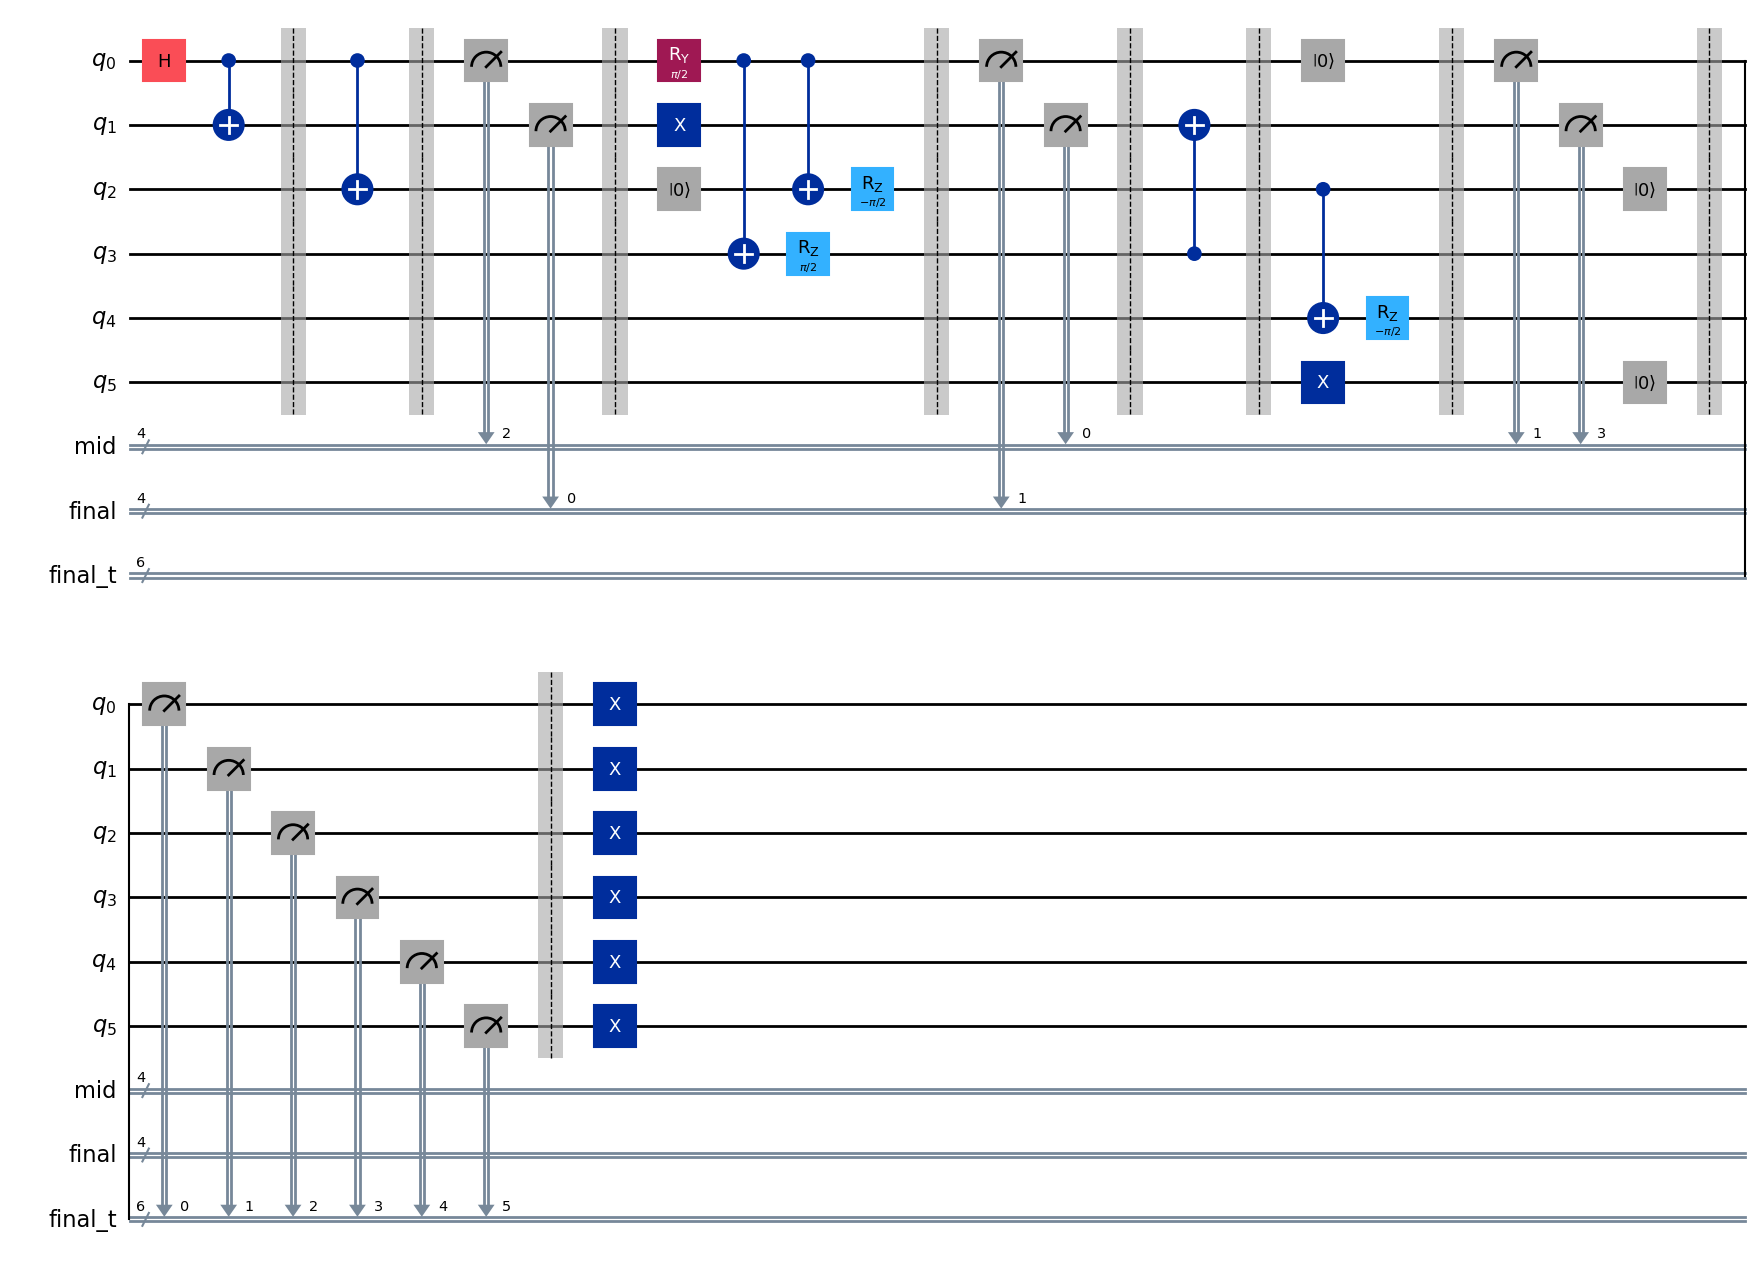

In [2]:
# Create explicit quantum and classical registers
N_q = 6 # Number of qubits in the code
N_m = 4 # Number of mid-measure classical bits

qreg = QuantumRegister(N_q, "q")
mid = ClassicalRegister(N_m, "mid")
final = ClassicalRegister(N_m, "final")
final_t = ClassicalRegister(N_q, "final_t")

n_qubits = N_q

# Build the circuit
qc = QuantumCircuit(qreg, mid, final, final_t)
# 1) Create a Bell state
qc.h(0)
qc.cx(0, 1)
qc.barrier()
qc.cx(0,2)
qc.barrier()
#qc.save_statevector(label="before_mid_measure")

# 2) Mid-circuit measure of qubit 0 into cbit 0
qc.measure(0, mid[2])
qc.measure(1, final[0])
qc.barrier()


# 3) Conditionally flip qubit 1 if the measurement was 1 (new control-flow API)
'''
with qc.if_test((qc.clbits[0], 1)):
    qc.x(1)
'''
qc.ry(np.pi/2, 0)
qc.cx(0,3)
qc.reset(2)
qc.x(1)
qc.rz(np.pi/2, 3)
qc.cx(0,2)
qc.rz(-np.pi/2, 2)
#qc.swap(1,2)


qc.barrier()
qc.measure(qreg[0], final[1])
qc.measure(qreg[1], mid[0])

qc.barrier()
qc.cx(3, 1)
qc.barrier()
qc.reset(0)
#qc.swap(2, 1)
qc.x(5)
qc.cx(2, 4)
qc.rz(-np.pi/2, 4)
qc.barrier()

# 4) Final measurement
qc.measure(0, 1)
qc.measure(1, 3)
qc.reset(2)
qc.reset(5)

qc.barrier()

qc.measure(range(N_q), final_t)
qc.barrier()

qc.x(range(N_q))


qc.draw("mpl")


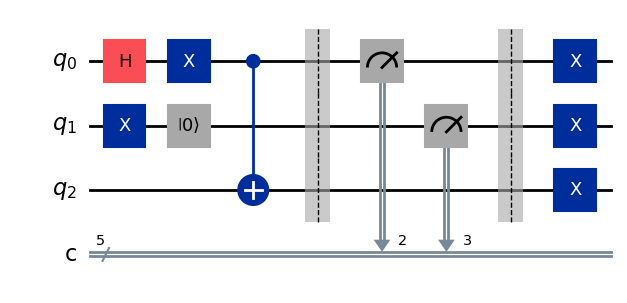

In [3]:
n_qubits = 3
qc = QuantumCircuit(3,5)
qc.h(0)
qc.x(0)
qc.x(1)
qc.cx(0,2)
qc.reset(1)
qc.barrier()
qc.measure(0,2)
qc.measure(1,3)
qc.barrier()
qc.x(0)
qc.x(1)
qc.x(2)

qc.draw("mpl")

### Run

In [4]:

sim = MrAndersonSimulator(gates=standard_gates, CircuitClass=EfficientCircuit)


initial_psi = np.zeros(2**n_qubits)
initial_psi[0] = 1.0  # set |00...0⟩
initial_layout = list(range(n_qubits))  # logical qubit 0→physical 0, 1→1, etc.
shots = 1

config = {
    "backend": {
        "hub": "ibm-q",
        "group": "open",
        "project": "main",
        "device_name": backend_name,
        "crn": CRN
    },
    "run": {
        "shots": shots,
        "qubits_layout": initial_layout,
        "psi0": initial_psi
    }
}

backend_config = config["backend"]
backend = setup_backend(Token=IBM_TOKEN, **backend_config)
run_config = config["run"]

qubits_layout = run_config["qubits_layout"]
device_param = DeviceParameters(qubits_layout)
device_param.load_from_backend(backend)
device_param_lookup = device_param.__dict__()

needs_controlflow = any(isinstance(op.operation, ControlFlowOp) for op in qc.data)

t_circ = transpile(
    qc,
    backend,
    initial_layout=qubits_layout,
    seed_transpiler=42,
    optimization_level=0,
    **({} if needs_controlflow else {"scheduling_method": "asap"})
)

# Add this right after transpilation, before sim.run()
print("\n=== CIRCUIT COMPARISON ===")
print(f"Original circuit depth: {qc.depth()}")
print(f"Transpiled circuit depth: {t_circ.depth()}")

# Compare reset operations
print("\n--- Original Circuit Resets ---")
for i, instr in enumerate(qc.data):
    if instr.operation.name == "reset":
        q_idx = qc.find_bit(instr.qubits[0]).index
        print(f"  Instruction #{i}: Reset on qubit {q_idx}")

print("\n--- Transpiled Circuit Resets ---")
for i, instr in enumerate(t_circ.data):
    if instr.operation.name == "reset":
        q_idx = t_circ.find_bit(instr.qubits[0]).index
        print(f"  Instruction #{i}: Reset on qubit {q_idx}")


# Extract the final layout (maps logical -> physical qubits)
final_layout = None
if hasattr(t_circ, '_layout') and t_circ._layout is not None:
    layout_obj = t_circ._layout
    
    # Get the final layout as a list: final_layout[logical_qubit] = physical_qubit
    if hasattr(layout_obj, 'final_index_layout'):
        final_layout = layout_obj.final_index_layout()
    elif hasattr(layout_obj, 'get_virtual_bits'):
        # Alternative method for older Qiskit versions
        final_layout = [layout_obj.get_virtual_bits()[qc.qubits[i]] for i in range(len(qc.qubits))]

print("Final qubit mapping (logical -> physical):", final_layout)

# Create inverse mapping: physical -> logical
if final_layout:
    physical_to_logical = {phys: log for log, phys in enumerate(final_layout)}
else:
    # No layout change, identity mapping
    physical_to_logical = {i: i for i in range(n_qubits)}

print("Physical to logical mapping:", physical_to_logical)

res  = sim.run(
    t_qiskit_circ=t_circ, 
    qubits_layout=qubits_layout, 
    psi0=np.array(run_config["psi0"]), 
    shots=run_config["shots"], 
    device_param=device_param_lookup,
    nqubit=n_qubits,
    )


counts = res["probs"]
results = res["results"]

print("Mid-circuit measurement results", results)
#print("Final measurement counts:", final_counts)
print("Final measurement probabilities:", counts)


=== CIRCUIT COMPARISON ===
Original circuit depth: 5
Transpiled circuit depth: 37

--- Original Circuit Resets ---
  Instruction #4: Reset on qubit 1

--- Transpiled Circuit Resets ---
  Instruction #10: Reset on qubit 1
Final qubit mapping (logical -> physical): [0, 2, 1]
Physical to logical mapping: {0: 0, 2: 1, 1: 2}
No swaps detected in chunk
Reset on qubit:  1

No swaps detected in chunk
No swaps detected in chunk
---- Preprocessed data ----
Chunk 0: rz[0] , sx[0] , rz[0] , x[0] , rz[0] , rz[0] , sx[0] , rz[0] , delay[0] , x[1]
Fancy 1: reset_qubits qubits=[1]
Chunk 2: rz[1] , rz[1] , sx[1] , rz[1] , sx[2] , rz[2] , sx[2] , rz[2] , delay[2] , ecr[2, 1] , rz[1] , sx[1] , rz[1] , sx[1] , rz[2] , sx[2] , rz[2] , rz[2] , delay[2] , ecr[2, 1] , rz[1] , rz[1] , sx[1] , rz[1] , delay[1] , sx[2] , rz[2] , sx[2] , rz[2] , ecr[2, 1] , rz[1] , sx[1] , rz[1] , rz[1] , rz[1] , sx[1] , rz[1] , rz[1] , rz[1] , sx[1] , rz[1] , ecr[1, 0] , rz[0] , sx[0] , rz[0] , x[0] , rz[1] , sx[1] , rz[1] , de

=== Original Circuit ===
=== Transpiled Circuit ===


KeyError: 3

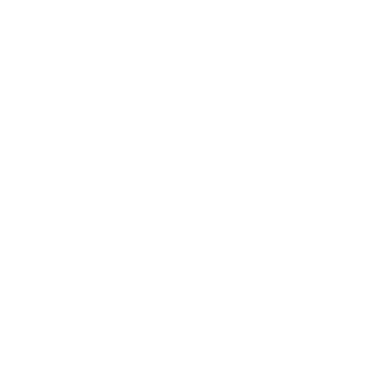

In [5]:
# Before preprocessing
print("=== Original Circuit ===")
qc.draw("mpl")

# After transpilation
print("=== Transpiled Circuit ===")
t_circ.draw("mpl")

# This is what your preprocessing sees:
for i, instr in enumerate(t_circ.data):
    if instr.operation.name == "reset":
        q_idx = t_circ.find_bit(instr.qubits[0]).index
        print(f"Reset #{i} on qubit {q_idx}")

In [ ]:
print(shots)

In [ ]:
# --- Build mid-circuit bitstrings directly from your library output ---
combined_mid_strings = []
for shot in results:
    # each shot["mid"] is a list of measurement events
    bitstring = "".join(str(event["outcome"][0]) for event in shot["mid"])
    combined_mid_strings.append(bitstring)

# --- Count occurrences ---
mid_counts = Counter(combined_mid_strings)

# --- Plot histogram ---
labels = sorted(mid_counts.keys())
values = [mid_counts[k] for k in labels]

plt.figure(figsize=(8, 5))
plt.bar(labels, values, color="cornflowerblue")
plt.xlabel("Mid-circuit measurement bitstring (library order)")
plt.ylabel("Count")
plt.title("Mid-circuit measurement outcomes across all shots")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# --- Optional printout ---
print("Mid-circuit measurement counts:", dict(mid_counts))

